# Diving deeper into the data structure

This tutorial will give you a more in depth introduction of **deep**doctection's data model. This is helpful, if you want to introduce layout structures trained by new models. 

In [ ]:
import deepdoctection as dd
from matplotlib import pyplot as plt

## Page and Image

![page](./pics/dd_page_image.png)

The `Page` object is a consumer class and a subclass of the `Image` object. The `Page` object simplifies the generic `Image` data class concept. It contains numerous attributes defined as `property` and thus represents a more content-driven view of the extracted data. For example, a `Page` contains `layouts`, `words` and `tables`. These concepts do not exist on the `Image` level.

![image](./pics/dd_image.png)

The `Image` object together with its `Annotation`s forms the **deep**doctection data model. All information that can be retrieved via the `Page` object is already in the `Image` object. `Image` has an attribute for saving `SummaryAnnotation`s. `SummaryAnnotation` is a class that allows you to store top level information of a document page (e.g. document type). 
Even more essential is the attribute `annotations`. This list saves all `ImageAnnotation`. Every instance from `Page.layouts`, `Page.words` or `Page.tables` is derived from an `ImageAnnotation` instance.

Datasets used to train models or document pages processed through a pipeline are always passed in `Image` instances, never in `Page` instances. As said before, the `Page` instance only plays a role for the consumer who wants to have extracted information from a document page easily accessible. 

`ImageAnnotation` are objects that can be detected on a document page. This can be layout section (paragraphs, text blocks, image captions) or text lines or even words. `ImageAnnotation` have a `category_name`, `category_id` and an `annotation_id`. The `annotation_id` is the unique identifier for the instance. 
`ImageAnnotation` has a dict attribute `sub_categories`. Here, everything related to the `ImageAnnotation` can be stored. 

To have a practical example at hand, we use the JSON file we created in the [Get_Started notebook](./Analyzer_Get_Started.ipynb). You can find this JSON file in the sample folder of this repo as well.

In [2]:
path = "/home/janis/Documents/Repos/notebooks/sample/test.json"
page = dd.Page.from_file(file_path="/home/janis/Documents/Repos/notebooks/sample/test.json") # "/path/to/dir/test.json")

image = page.image_orig # page instance keeps the original image

The `Image` object has an `image_id` that uniquely defines the image object. Once the `Image` has been instantiated it will remain fix. 

On the other hand there is a `state_id` that changes once the whole `image` instance changes.

In [3]:
print(f"image_id: {image.image_id} state_id: {image.state_id}")

image_id: 2aa98b36-196e-3cdf-af09-8f2d885d5f88 state_id: 98eebb5d-f319-3094-94af-fb0f02229dad


Let's look at the `word` object at the bottom from the **Get_Started** notebook. Having the `annotation_id` it is easy to find it among all other objects. 

In [5]:
word = page.get_annotation(annotation_ids='844631a5-5ddb-3ba8-b81a-bb9f05604d58')[0] # get_annotation returns a list

We have a 1:1 correspondence between a `Layout`, `Word`, `Table`, `Cell` on the `Page` level and `ImageAnnotation` on the `Image` level. In fact, all layout sections are sub classes of `ImageAnnotation`.

In [6]:
word.__class__.__bases__[0].__bases__[0]

deepdoctection.datapoint.annotation.ImageAnnotation

We can even retrieve the `ImageAnnotation` instance from which the `word` instance has been derived.

In [7]:
ann = image.get_annotation(annotation_ids='844631a5-5ddb-3ba8-b81a-bb9f05604d58')[0]

Categories and keys are stored as members of special classes called ObjectTypes. 
It is not possible to define e.g. categories without assigning them to some ObjectTypes. 

In [8]:
ann.sub_categories.keys()

dict_keys([<WordType.CHARACTERS>, <WordType.BLOCK>, <WordType.TEXT_LINE>, <Relationships.READING_ORDER>])

In [9]:
ann.category_name

<LayoutType.WORD>

## `ObjectTypes`

`ObjectTypes` is a string based enum. For related keys or categories a subclass of `ObjectTypes` is formed. A `object_types_registry` is responsible for cataloging the `ObjectTypes`.

In [10]:
dd.object_types_registry.get_all()

{'DefaultType': <enum 'DefaultType'>,
 'PageType': <enum 'PageType'>,
 'SummaryType': <enum 'SummaryType'>,
 'DocumentType': <enum 'DocumentType'>,
 'LayoutType': <enum 'LayoutType'>,
 'TableType': <enum 'TableType'>,
 'CellType': <enum 'CellType'>,
 'WordType': <enum 'WordType'>,
 'TokenClasses': <enum 'TokenClasses'>,
 'BioTag': <enum 'BioTag'>,
 'TokenClassWithTag': <enum 'TokenClassWithTag'>,
 'Relationships': <enum 'Relationships'>,
 'Languages': <enum 'Languages'>,
 'DatasetType': <enum 'DatasetType'>}

In [11]:
word = dd.object_types_registry.get("WordType")
for word_type in word:
    print(word_type)

WordType.CHARACTERS
WordType.BLOCK
WordType.TOKEN_CLASS
WordType.TAG
WordType.TOKEN_TAG
WordType.TEXT_LINE
WordType.CHARACTER_TYPE
WordType.PRINTED
WordType.HANDWRITTEN


## `ImageAnnotation` and sub categories

We have already mentioned that it is not directly possible to modify values and we do not recommmend modifying values as we are now going to describe how it can be done. We think however, it is worth to show you how it 
can be done theoretically, because it gives us the opportunity to explore the **deep**doctection data structure a bit more.

`ImageAnnotation` and `CategoryAnnotation` can have sub categories. If available, they can be found by using the `get_sub_category` method.

In [12]:
character_ann = ann.get_sub_category("characters")
character_ann

ContainerAnnotation(active=True, _annotation_id='ded39c8a-72c0-335b-853f-e6c8b50fbfbc', service_id=None, model_id=None, session_id=None, category_name=<WordType.CHARACTERS>, _category_name=<WordType.CHARACTERS>, category_id=-1, score=0.91, sub_categories={}, relationships={}, value='Gesamtvergütung')

Beside `ImageAnnotation` and `CategoryAnnotation` there is also a `ContainerAnnotation` class. It only differs from `CategoryAnnotation` by having an attribute `value` that can store a string or a value. It is now clear that all `Annotation` classes are dataclasses and therefore work as a storage. Having these at hand, we can now modify their values and these updates will persist!  

In [13]:
character_ann.value="Gesamtvergütungsbericht"

In [15]:
ann.category_name="line"

As already mentioned, `category_name` and sub category keys require values that are `ObjectTypes` members. If the value does not exist as
registered `ObjectTypes` members an error is raised.

In [16]:
ann.category_name="headline"

KeyError: 'String headline does not correspond to a registered ObjectType'

Adding an `ObjectTypes` with the required Enum member, registering and updating will then
allow you to use this category.

In [17]:
@dd.object_types_registry.register("NewspaperType")
class NewspaperType(dd.ObjectTypes):

    headline = "headline"
    advertising = "advertising"
    
dd.update_all_types_dict()

In [18]:
ann.category_name="headline" # no key error anymore

## Adding an `ImageAnnotation`

Suppose, we want to add a new word to the page corpus. We have to define an `ImageAnnotation` and need to dump it. 

In [19]:
new_ann = dd.ImageAnnotation(category_name="word")
new_ann  # No annotation_id has been assigned yet. This will happen once we dump the ImageAnnotation to the image.

ImageAnnotation(active=True, _annotation_id=None, service_id=None, model_id=None, session_id=None, category_name=<LayoutType.WORD>, _category_name=<LayoutType.WORD>, category_id=-1, score=None, sub_categories={}, relationships={}, bounding_box=None)

In [20]:
bbox = dd.BoundingBox(absolute_coords=False, ulx=0.5,uly=0.7,lrx=0.6,lry=0.9) # setting up a bounding box

In [21]:
new_ann.bounding_box = bbox

In [22]:
image.dump(new_ann) # dump the annotation

In [23]:
new_ann # There is an annotation_id available right now.

ImageAnnotation(active=True, _annotation_id='0de5d9cf-f136-321d-b177-08c06157e600', service_id=None, model_id=None, session_id=None, category_name=<LayoutType.WORD>, _category_name=<LayoutType.WORD>, category_id=-1, score=None, sub_categories={}, relationships={}, bounding_box=BoundingBox(absolute_coords=False, ulx=0.5, uly=0.7, lrx=0.6, lry=0.9, height=0.20000000000000007, width=0.09999999999999998))

In [24]:
print(f"image_id: {image.image_id} state_id: {image.state_id}") # state_id has changed

image_id: 2aa98b36-196e-3cdf-af09-8f2d885d5f88 state_id: b673b2b1-18c6-3b94-bbc1-14432b564ce4


## Adding a `ContainerAnnotation` to an `ImageAnnotation`

In [27]:
container_ann = dd.ContainerAnnotation(category_name=dd.WordType.CHARACTERS, value='Gesamtvergütung')
new_ann.dump_sub_category(dd.WordType.CHARACTERS, container_ann)

In [28]:
new_ann # ContainerAnnotation is registered and added to ImageAnnotation

ImageAnnotation(active=True, _annotation_id='0de5d9cf-f136-321d-b177-08c06157e600', service_id=None, model_id=None, session_id=None, category_name=<LayoutType.WORD>, _category_name=<LayoutType.WORD>, category_id=-1, score=None, sub_categories={<WordType.CHARACTERS>: ContainerAnnotation(active=True, _annotation_id='aafcb5b9-80ec-3bba-bd33-e93daac08c4d', service_id=None, model_id=None, session_id=None, category_name=<WordType.CHARACTERS>, _category_name=<WordType.CHARACTERS>, category_id=-1, score=None, sub_categories={}, relationships={}, value='Gesamtvergütung')}, relationships={}, bounding_box=BoundingBox(absolute_coords=False, ulx=0.5, uly=0.7, lrx=0.6, lry=0.9, height=0.20000000000000007, width=0.09999999999999998))

## Sub images from given `ImageAnnotation`

In some situation we want to operate on a speicific part of the whole image that is defined by 
some `ImageAnnotation`. E.g. when building table recognition system, first we detect the table region, then we crop
the table and perform cell/row/column detection on the sub image.

We therefore need a simple way to convert an `ImageAnnotation` into a corresponding `Image` object.

In [29]:
image.image_ann_to_image(annotation_id='844631a5-5ddb-3ba8-b81a-bb9f05604d58')

`image_ann_to_image` adds an `Image` object to the `ImageAnnotation` with `image_id` being the same as the `annotation_id`. 

In [30]:
ann = image.get_annotation(annotation_ids='844631a5-5ddb-3ba8-b81a-bb9f05604d58')[0]
ann.image

Image(file_name='sample_2.png', location='/home/janis/Public/notebooks/pics/samples/sample_2/sample_2.png', document_id='844631a5-5ddb-3ba8-b81a-bb9f05604d58', _image_id='844631a5-5ddb-3ba8-b81a-bb9f05604d58', embeddings={'844631a5-5ddb-3ba8-b81a-bb9f05604d58': BoundingBox(absolute_coords=True, ulx=0.0, uly=0.0, lrx=131.0, lry=15.0, height=15.0, width=131.0), '2aa98b36-196e-3cdf-af09-8f2d885d5f88': BoundingBox(absolute_coords=True, ulx=146.0, uly=1481.0, lrx=277.0, lry=1496.0, height=15.0, width=131.0)}, annotations=[])

There are also embedding bounding boxes that describe the relative position to the full image. 

In [31]:
ann.image.get_embedding(image.image_id)

BoundingBox(absolute_coords=True, ulx=146.0, uly=1481.0, lrx=277.0, lry=1496.0, height=15.0, width=131.0)

There is a second bounding box that describes the position of the image in terms of its own coordinates. 

In [32]:
ann.image.get_embedding(ann.annotation_id)

BoundingBox(absolute_coords=True, ulx=0.0, uly=0.0, lrx=131.0, lry=15.0, height=15.0, width=131.0)

Setting `crop_image=True` will even store the pixel values of the sub image.

In [33]:
image.image_ann_to_image(annotation_id='844631a5-5ddb-3ba8-b81a-bb9f05604d58',crop_image=True)

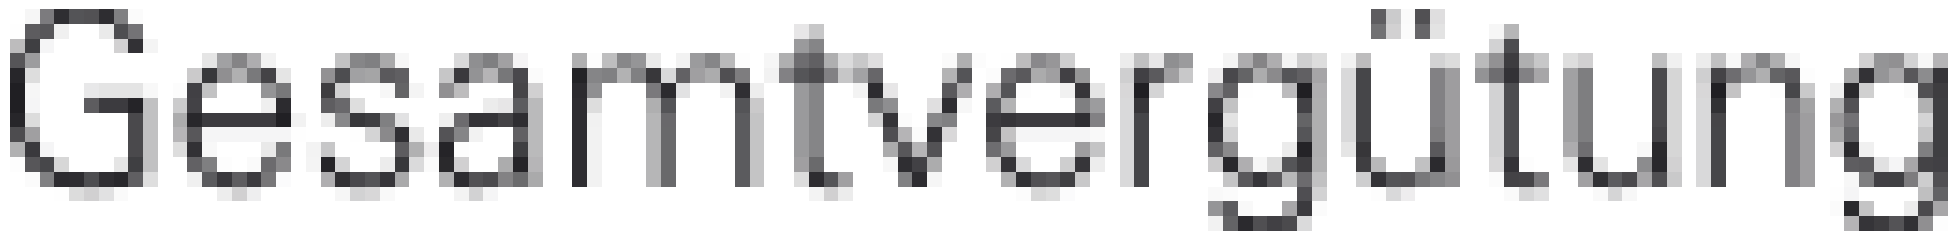

In [34]:
plt.figure(figsize = (25,17))
plt.axis('off')
plt.imshow(ann.image.image)

In [35]:
image.get_categories_from_current_state()

{<LayoutType.CELL>,
 <LayoutType.COLUMN>,
 <NewspaperType.headline>,
 <LayoutType.LIST>,
 <LayoutType.ROW>,
 <LayoutType.TABLE>,
 <LayoutType.TEXT>,
 <LayoutType.TITLE>,
 <LayoutType.WORD>}